In [2]:
# Todas las librerias de las que haremos uso
import os
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import xgboost as xgb
import time
import seaborn as sns

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

In [3]:
# Rutas definidas para que sea más facil hacer el cambio
base_path = 'C:/Users/JAVIER/Documents/JavierGamez/Proyectos/1.ProyectoCiberData/data'
file_path = os.path.join(base_path,'CICFlowMeter_out.csv')
file_parquet = os.path.join(base_path,'CIC_Full_Data.parquet')

In [4]:
import pandas as pd
import numpy as np

# 1. Carga optimizada (solo las primeras 5 filas para inspección)
df_check = pd.read_csv(file_path, nrows=5)

# 2. Diagnóstico de estructura
print("--- Columnas Detectadas ---")
print(df_check.columns.tolist())

# 3. Carga completa para análisis de integridad
df = pd.read_csv(file_path)

print("\n--- Diagnóstico de Salud de Datos ---")
info = pd.DataFrame({
    'Nulos': df.isnull().sum(),
    'Infinitos': df.isin([np.inf, -np.inf]).sum(),
    'Tipo de Dato': df.dtypes
})
print(info[info['Nulos'] > 0] if df.isnull().any().any() else "No hay Nulos")
print(info[info['Infinitos'] > 0] if df.isin([np.inf, -np.inf]).any().any() else "No hay Infinitos")

# 4. Verificación del Target (La columna de ataque)
target_col = 'Label' 
if target_col in df.columns:
    print("\n--- Distribución de Clases ---")
    print(df[target_col].value_counts(normalize=True))
else:
    print(f"\n¡ALERTA!: No se encontró la columna '{target_col}'.")

--- Columnas Detectadas ---
['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Fl

In [5]:
# 1. Crear la columna Target Binaria
df['Binary_Label'] = df['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

# 2. Eliminación de columnas de "Fuga de Información"
# Estas columnas hacen que el modelo sea un "fraude" porque memorizan el entorno
cols_to_drop = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Label']
df_clean = df.drop(columns=cols_to_drop)

# 3. Codificación de Protocolo
print("Variedad de Protocolos:", df_clean['Protocol'].unique())

# 4. Verificación del nuevo balance
print("\n--- Nuevo Balance Binario ---")
print(df_clean['Binary_Label'].value_counts(normalize=True))
print("\n--- Conteo Real ---")
print(df_clean['Binary_Label'].value_counts())

Variedad de Protocolos: [ 6 17]

--- Nuevo Balance Binario ---
Binary_Label
0    0.974696
1    0.025304
Name: proportion, dtype: float64

--- Conteo Real ---
Binary_Label
0    3450658
1      89583
Name: count, dtype: int64


In [6]:
# 1. Calcular matriz de correlación solo de variables numéricas
corr_matrix = df_clean.drop(columns=['Binary_Label']).corr().abs()

# 2. Seleccionar el triángulo superior de la matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Identificar columnas con correlación superior al 95%
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# 1. Definir las columnas que decidimos salvar por criterio experto
rescatadas = ['PSH Flag Count', 'ACK Flag Count', 'Idle Mean', 'Idle Max', 'Idle Min', 'Fwd IAT Mean']

# 2. Filtrar la lista original de eliminación
to_drop_final = [col for col in to_drop if col not in rescatadas]

# 3. Crear el DataFrame final
df_final = df_clean.drop(columns=to_drop_final)

print(f"--- Dataset Final Consolidado ---")
print(f"Columnas eliminadas: {len(to_drop_final)}")
print(f"Dimensiones finales: {df_final.shape}")
print(f"¿Están las columnas que rescatamos?: {[col in df_final.columns for col in rescatadas]}")

--- Dataset Final Consolidado ---
Columnas eliminadas: 20
Dimensiones finales: (3540241, 60)
¿Están las columnas que rescatamos?: [True, True, True, True, True, True]


In [7]:
from sklearn.model_selection import train_test_split

# Separar características (X) y etiqueta (y)
X = df_final.drop(columns=['Binary_Label'])
y = df_final['Binary_Label']

# División 80/20 con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Cálculo del factor de escala para XGBoost 
ratio_balance = (y_train == 0).sum() / (y_train == 1).sum()

print(f"--- Verificación de Datos ---")
print(f"Registros de entrenamiento: {X_train.shape[0]}")
print(f"Registros de prueba: {X_test.shape[0]}")
print(f"Ratio de desbalance (scale_pos_weight): {ratio_balance:.2f}")

--- Verificación de Datos ---
Registros de entrenamiento: 2832192
Registros de prueba: 708049
Ratio de desbalance (scale_pos_weight): 38.52


In [8]:
import xgboost as xgb
import time

model_base = xgb.XGBClassifier(
    n_estimators=150,       # Un poco más de árboles para capturar complejidad
    max_depth=7,            # Profundidad moderada para evitar memorización
    learning_rate=0.1,
    scale_pos_weight=1,    
    tree_method='hist',     # Crucial para 3.5M de registros 
    device='cpu',           
    random_state=42,
    n_jobs=-1               
)

print("Iniciando entrenamiento del modelo conservador")
start_time = time.time()

model_base.fit(X_train, y_train)

end_time = time.time()
print(f"Entrenamiento completado en {end_time - start_time:.2f} segundos.")

Iniciando entrenamiento del modelo conservador
Entrenamiento completado en 38.76 segundos.


--- RESULTADOS MODELO CONSERVADOR ---
F0.5 Score: 0.8605

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690132
           1       0.87      0.83      0.85     17917

    accuracy                           0.99    708049
   macro avg       0.93      0.91      0.92    708049
weighted avg       0.99      0.99      0.99    708049



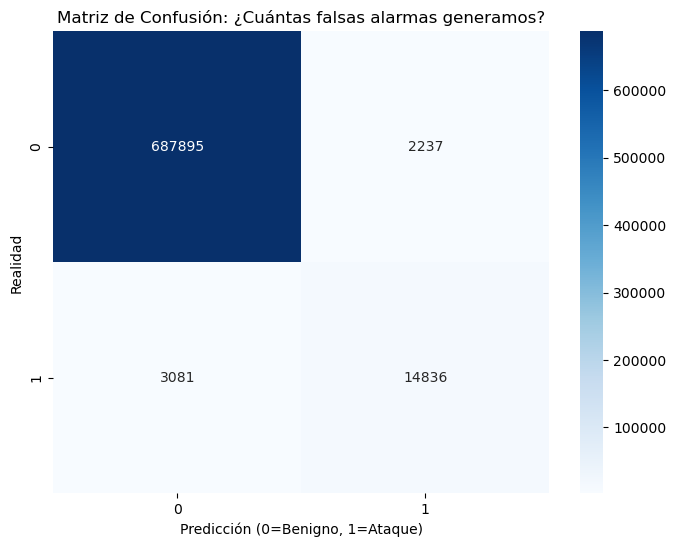

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Predicciones
y_pred = model_base.predict(X_test)

# 2. Cálculo de F0.5 (Nuestra métrica estrella)
f05 = fbeta_score(y_test, y_pred, beta=0.5)

# 3. Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

print(f"--- RESULTADOS MODELO CONSERVADOR ---")
print(f"F0.5 Score: {f05:.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Visualización
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción (0=Benigno, 1=Ataque)')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión: ¿Cuántas falsas alarmas generamos?')
plt.show()

In [10]:
# 1. Obtener las probabilidades en lugar de las etiquetas directas
y_probs = model_base.predict_proba(X_test)[:, 1]

# 2. Aplicar un umbral de confianza del 90%
threshold = 0.90
y_pred_extreme = (y_probs >= threshold).astype(int)

# 3. Nueva evaluación
print(f"--- EVALUACIÓN CON UMBRAL DE {threshold*100}% ---")
print(confusion_matrix(y_test, y_pred_extreme))
print(classification_report(y_test, y_pred_extreme))
print(f"Nuevo F0.5: {fbeta_score(y_test, y_pred_extreme, beta=0.5):.4f}")

--- EVALUACIÓN CON UMBRAL DE 90.0% ---
[[689749    383]
 [  8809   9108]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    690132
           1       0.96      0.51      0.66     17917

    accuracy                           0.99    708049
   macro avg       0.97      0.75      0.83    708049
weighted avg       0.99      0.99      0.99    708049

Nuevo F0.5: 0.8149


--- ANÁLISIS DEL PUNTO CIEGO POR CATEGORÍA ---
                Ataques Omitidos  Total en Test  % de Ceguera (Fuga)
Label                                                               
Analysis                      66             68            97.058824
Fuzzers                     5542           5844            94.832307
Shellcode                    211            442            47.737557
Backdoor                      40             84            47.619048
DoS                          407            925            44.000000
Worms                         18             45            40.000000
Generic                      230            914            25.164114
Exploits                    1536           6370            24.113030
Reconnaissance               759           3225            23.534884


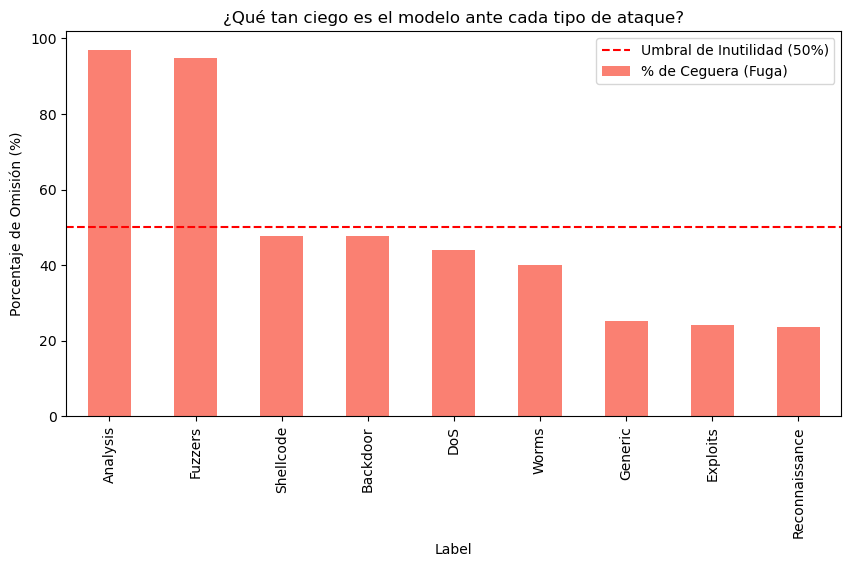

In [11]:
# 1. Identificar los índices de los Falsos Negativos 
false_negatives_idx = X_test[(y_test == 1) & (y_pred_extreme == 0)].index

# 2. Recuperar las etiquetas originales para esos fallos
# Usamos el dataframe 'df' original que contiene la columna 'Label' multiclase
missed_attacks = df.loc[false_negatives_idx, 'Label'].value_counts()
total_attacks = df.loc[X_test[y_test == 1].index, 'Label'].value_counts()

# 3. Calcular el % de "Ceguera" por categoría
blind_spot_ratio = (missed_attacks / total_attacks) * 100

# 4. Mostrar resultados
import pandas as pd
analysis_df = pd.DataFrame({
    'Ataques Omitidos': missed_attacks,
    'Total en Test': total_attacks,
    '% de Ceguera (Fuga)': blind_spot_ratio
}).sort_values(by='% de Ceguera (Fuga)', ascending=False)

print("--- ANÁLISIS DEL PUNTO CIEGO POR CATEGORÍA ---")
print(analysis_df)

# Visualización
analysis_df['% de Ceguera (Fuga)'].plot(kind='bar', color='salmon', figsize=(10,5))
plt.title('¿Qué tan ciego es el modelo ante cada tipo de ataque?')
plt.ylabel('Porcentaje de Omisión (%)')
plt.axhline(y=50, color='r', linestyle='--', label='Umbral de Inutilidad (50%)')
plt.legend()
plt.show()

In [12]:
# Analizar qué variables fueron 'insignificantes' para los fallos
import pandas as pd

# 1. Obtener importancia del modelo
importancias = pd.Series(model_base.feature_importances_, index=X_test.columns)

# 2. Ver las 15 variables que el modelo considera más importantes
print("--- TOP 15 CARACTERÍSTICAS DEL MODELO ---")
print(importancias.sort_values(ascending=False).head(15))

# 3. ¿Qué valores tienen estas variables en los ataques que OMITIMOS?
X_missed = X_test[(y_test == 1) & (y_probs < 0.90)]
print("\n--- PROMEDIO DE VARIABLES EN ATAQUES OMITIDOS (Anomalías) ---")
print(X_missed[importancias.sort_values(ascending=False).head(5).index].mean())

--- TOP 15 CARACTERÍSTICAS DEL MODELO ---
Bwd Packets/s             0.199480
FWD Init Win Bytes        0.156411
PSH Flag Count            0.108329
Down/Up Ratio             0.107744
Packet Length Max         0.104241
Bwd Packet Length Min     0.094199
Bwd Init Win Bytes        0.025141
SYN Flag Count            0.023343
Fwd Packet Length Mean    0.022350
Src Port                  0.018988
Total Bwd packets         0.017877
Dst Port                  0.017001
Protocol                  0.014120
Bwd Packet Length Max     0.009570
FIN Flag Count            0.009437
dtype: float32

--- PROMEDIO DE VARIABLES EN ATAQUES OMITIDOS (Anomalías) ---
Bwd Packets/s            17.787988
FWD Init Win Bytes    13982.712907
PSH Flag Count            0.237825
Down/Up Ratio             0.077080
Packet Length Max       233.386877
dtype: float64


In [13]:
# 1. Ratio de Bytes por Paquete (Detecta payloads anómalos en Fuzzers)
df_final['Bytes_per_Packet'] = df['Total Length of Fwd Packet'] / (df['Total Fwd Packet'] + 1)

# 2. Ratio de Intensidad (Relaciona el tiempo con el volumen)
df_final['Flow_Intensity'] = df_final['Packet Length Max'] / (df_final['Flow Duration'] + 1)

# 3. Verificación de las nuevas columnas
print(df_final[['Bytes_per_Packet', 'Flow_Intensity']].describe())

       Bytes_per_Packet  Flow_Intensity
count      3.540241e+06    3.540241e+06
mean       4.958858e+01    2.139060e-01
std        1.397777e+02    4.307355e+00
min        0.000000e+00    0.000000e+00
25%        0.000000e+00    0.000000e+00
50%        6.845070e+00    1.247810e-03
75%        3.000000e+01    4.639093e-02
max        1.427101e+03    4.896667e+02


In [14]:
# 1. Asegurar que X incluya las nuevas columnas y no tenga basura
X_evolved = df_final.drop(columns=['Binary_Label'])
y_evolved = df_final['Binary_Label']

# Re-división (importante para incluir las nuevas columnas)
X_train_ev, X_test_ev, y_train_ev, y_test_ev = train_test_split(
    X_evolved, y_evolved, test_size=0.2, random_state=42, stratify=y_evolved
)

# 2. Configuración del Modelo "Equilibrio Informado"
model_balanced = xgb.XGBClassifier(
    n_estimators=200,        # Más árboles para procesar las nuevas variables
    max_depth=8,             # Un poco más profundo para capturar la Flow_Intensity
    learning_rate=0.05,      # Tasa más lenta para una convergencia más fina
    scale_pos_weight=6,      # Peso moderado para rescatar ataques sutiles
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

print("Entrenando modelo de Equilibrio Informado...")
model_balanced.fit(X_train_ev, y_train_ev)

# 3. Evaluación con Umbral Ajustado (80%)
y_probs_ev = model_balanced.predict_proba(X_test_ev)[:, 1]
y_pred_ev = (y_probs_ev >= 0.80).astype(int)

Entrenando modelo de Equilibrio Informado...


--- COMPARATIVA: MODELO CONSERVADOR VS EQUILIBRIO INFORMADO ---
Nuevo F0.5 Score: 0.8344

Reporte de Clasificación (Modelo Evolucionado):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    690132
           1       0.82      0.88      0.85     17917

    accuracy                           0.99    708049
   macro avg       0.91      0.94      0.92    708049
weighted avg       0.99      0.99      0.99    708049



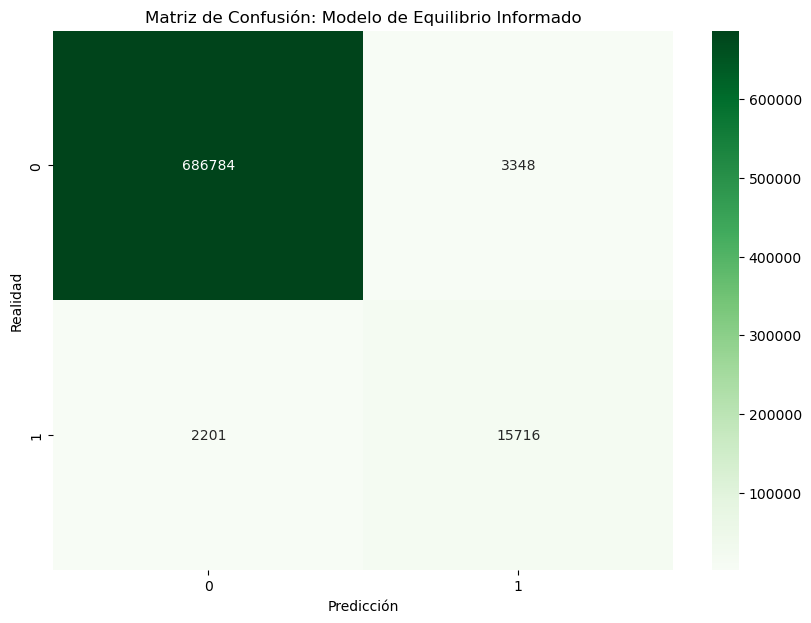


--- TABLA DE RESCATE DE CATEGORÍAS ---
                Ceguera Anterior (%)  Nueva Ceguera (%)
Analysis                       97.05          83.823529
Fuzzers                        94.83          32.221081
Shellcode                      47.73           7.692308
Backdoor                       47.61           1.190476
DoS                            44.00           5.729730
Worms                          40.00                NaN
Generic                        25.16           1.094092
Exploits                       24.11           2.543171
Reconnaissance                 23.53           0.031008


In [15]:
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generar predicciones con el umbral del 80%
y_pred_ev = (y_probs_ev >= 0.80).astype(int)

# 2. Nueva Matriz de Confusión
cm_ev = confusion_matrix(y_test_ev, y_pred_ev)

# 3. Nuevo Análisis de Punto Ciego (Brecha de Seguridad)
missed_idx_ev = X_test_ev[(y_test_ev == 1) & (y_pred_ev == 0)].index
missed_attacks_ev = df.loc[missed_idx_ev, 'Label'].value_counts()
total_attacks_ev = df.loc[X_test_ev[y_test_ev == 1].index, 'Label'].value_counts()
blind_spot_ev = (missed_attacks_ev / total_attacks_ev) * 100

# 4. Resultados en pantalla
print("--- COMPARATIVA: MODELO CONSERVADOR VS EQUILIBRIO INFORMADO ---")
print(f"Nuevo F0.5 Score: {fbeta_score(y_test_ev, y_pred_ev, beta=0.5):.4f}")
print("\nReporte de Clasificación (Modelo Evolucionado):")
print(classification_report(y_test_ev, y_pred_ev))

# Visualización de la Matriz
plt.figure(figsize=(10,7))
sns.heatmap(cm_ev, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión: Modelo de Equilibrio Informado')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Tabla de rescate
rescue_df = pd.DataFrame({
    'Ceguera Anterior (%)': [97.05, 94.83, 47.73, 47.61, 44.00, 40.00, 25.16, 24.11, 23.53],
    'Nueva Ceguera (%)': blind_spot_ev.reindex(['Analysis', 'Fuzzers', 'Shellcode', 'Backdoor', 'DoS', 'Worms', 'Generic', 'Exploits', 'Reconnaissance']).values
}, index=['Analysis', 'Fuzzers', 'Shellcode', 'Backdoor', 'DoS', 'Worms', 'Generic', 'Exploits', 'Reconnaissance'])

print("\n--- TABLA DE RESCATE DE CATEGORÍAS ---")
print(rescue_df)

--- REPORTE DE RESCATE TÉCNICO ---
                Ceguera Anterior (%)  Nueva Ceguera (%)  \
Fuzzers                        94.83          32.221081   
Backdoor                       47.61           1.190476   
Shellcode                      47.73           7.692308   
Worms                          40.00           0.000000   
DoS                            44.00           5.729730   
Generic                        25.16           1.094092   
Reconnaissance                 23.53           0.031008   
Exploits                       24.11           2.543171   
Analysis                       97.05          83.823529   

                Ataques Rescatados (%)  
Fuzzers                      62.608919  
Backdoor                     46.419524  
Shellcode                    40.037692  
Worms                        40.000000  
DoS                          38.270270  
Generic                      24.065908  
Reconnaissance               23.498992  
Exploits                     21.566829  
Analy

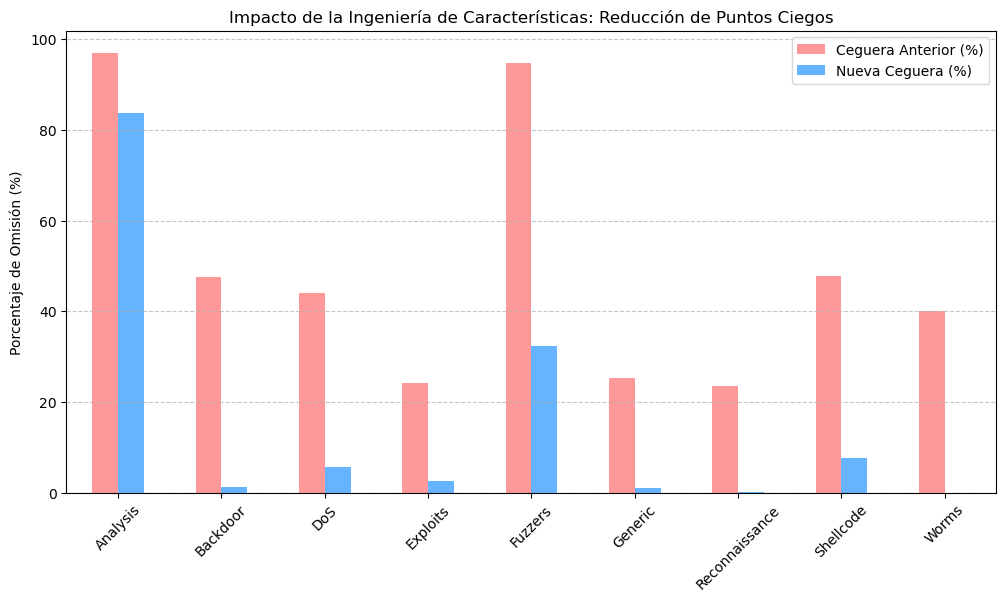

In [16]:
# 1. Identificar los índices de los Falsos Negativos del nuevo modelo (Equilibrio Informado)
# Usamos y_pred_ev que es el resultado del umbral al 80%
missed_idx_ev = X_test_ev[(y_test_ev == 1) & (y_pred_ev == 0)].index

# 2. Recuperar etiquetas originales y calcular nuevas tasas de ceguera
missed_attacks_ev = df.loc[missed_idx_ev, 'Label'].value_counts()
total_attacks_ev = df.loc[X_test_ev[y_test_ev == 1].index, 'Label'].value_counts()
blind_spot_ev = (missed_attacks_ev / total_attacks_ev) * 100

# 3. Crear DataFrame Comparativo de Rescate
ceguera_anterior = {
    'Analysis': 97.05, 'Fuzzers': 94.83, 'Shellcode': 47.73, 
    'Backdoor': 47.61, 'DoS': 44.00, 'Worms': 40.00, 
    'Generic': 25.16, 'Exploits': 24.11, 'Reconnaissance': 23.53
}

comparativa_df = pd.DataFrame({
    'Ceguera Anterior (%)': pd.Series(ceguera_anterior),
    'Nueva Ceguera (%)': blind_spot_ev
}).fillna(0) # Por si alguna categoría ahora tiene 0 fallos

# Calcular la mejora absoluta
comparativa_df['Ataques Rescatados (%)'] = comparativa_df['Ceguera Anterior (%)'] - comparativa_df['Nueva Ceguera (%)']

print("--- REPORTE DE RESCATE TÉCNICO ---")
print(comparativa_df.sort_values(by='Ataques Rescatados (%)', ascending=False))

# Visualización del impacto
comparativa_df[['Ceguera Anterior (%)', 'Nueva Ceguera (%)']].plot(kind='bar', figsize=(12,6), color=['#ff9999','#66b3ff'])
plt.title('Impacto de la Ingeniería de Características: Reducción de Puntos Ciegos')
plt.ylabel('Porcentaje de Omisión (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\JAVIER\AppData\Local\Temp\ipykernel_2028\839635658.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gain', y='Feature', data=importance_df.head(20), palette='viridis')


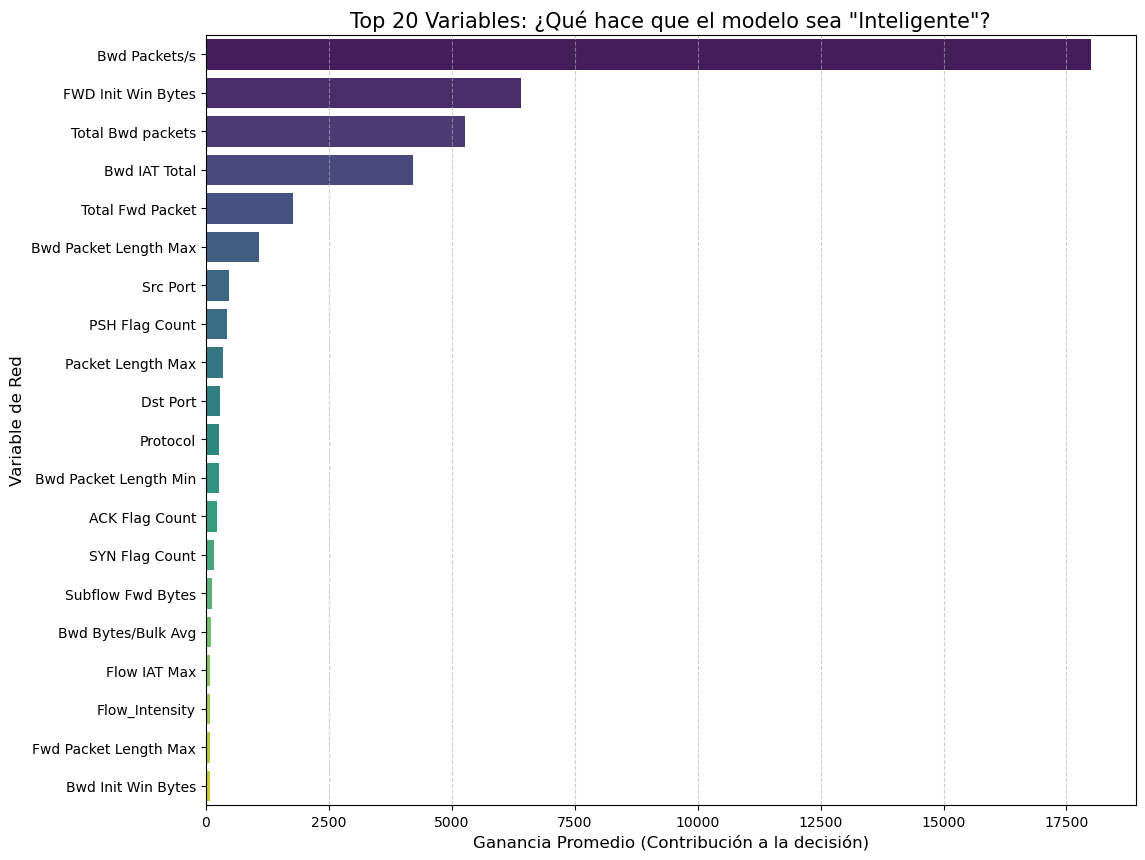

--- RENDIMIENTO DE LAS NUEVAS VARIABLES ---
Variable: Bytes_per_Packet | Ranking: 49 | Ganancia: 45.52
Variable: Flow_Intensity | Ranking: 50 | Ganancia: 86.41


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extraer la importancia basada ganancia
# El 'gain' es la métrica más robusta porque mide la contribución real a la precisión
importance_gain = model_balanced.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance_gain.keys()),
    'Gain': list(importance_gain.values())
}).sort_values(by='Gain', ascending=False)

# 2. Visualización
plt.figure(figsize=(12, 10))
sns.barplot(x='Gain', y='Feature', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Variables: ¿Qué hace que el modelo sea "Inteligente"?', fontsize=15)
plt.xlabel('Ganancia Promedio (Contribución a la decisión)', fontsize=12)
plt.ylabel('Variable de Red', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# 3. Verificación de nuestras "Super-Variables"
nuevas = ['Bytes_per_Packet', 'Flow_Intensity']
print("--- RENDIMIENTO DE LAS NUEVAS VARIABLES ---")
for var in nuevas:
    rank = importance_df[importance_df['Feature'] == var].index.tolist()
    rank_val = rank[0] + 1 if rank else "N/A"
    gain_val = importance_df.loc[importance_df['Feature'] == var, 'Gain'].values[0] if rank else 0
    print(f"Variable: {var} | Ranking: {rank_val} | Ganancia: {gain_val:.2f}")

--- TOP 15 PUERTOS DE DESTINO (ATAQUES) ---
Dst Port
80      5037
111     2505
179     1817
445     1662
25      1045
520      666
21       536
1723     499
143      374
514      362
110      350
135      207
53       142
8080     132
5060     121
Name: count, dtype: int64

--- TOP 15 PUERTOS DE DESTINO (BENIGNO) ---
Dst Port
80      79262
53      74785
6881    49807
5190    43126
25      32966
143     19617
21      18346
111     17143
22      11838
179      4716
520      1125
1723      631
445       526
860       432
514       378
Name: count, dtype: int64


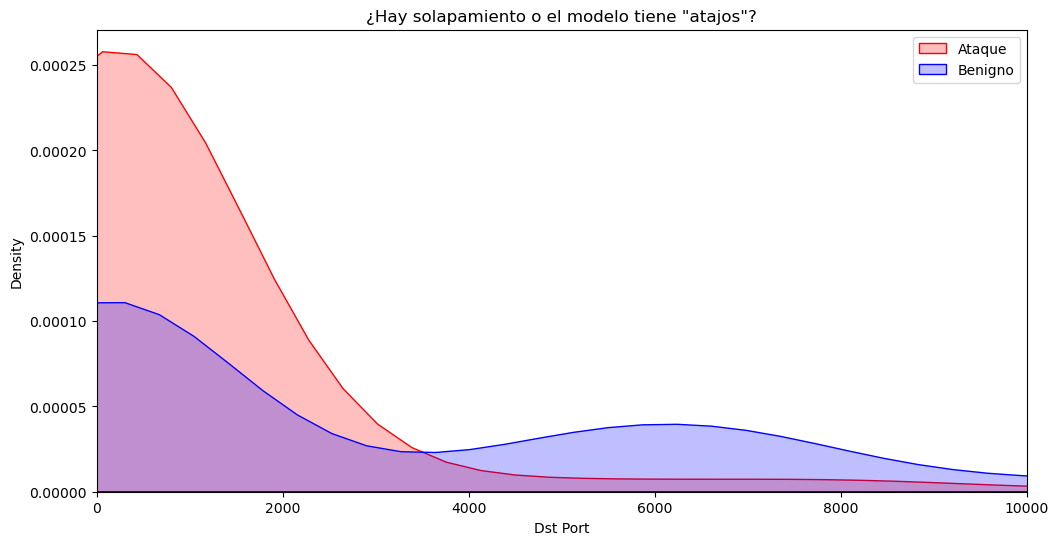

In [18]:
# 1. Análisis de Solapamiento, ver qu elos puertos son exclusivos de una sola clase o no 
top_n = 15

# Puertos más frecuentes en ataques vs tráfico benigno
dst_ports_attack = X_test_ev[y_test_ev == 1]['Dst Port'].value_counts().head(top_n)
dst_ports_benign = X_test_ev[y_test_ev == 0]['Dst Port'].value_counts().head(top_n)

print("--- TOP 15 PUERTOS DE DESTINO (ATAQUES) ---")
print(dst_ports_attack)
print("\n--- TOP 15 PUERTOS DE DESTINO (BENIGNO) ---")
print(dst_ports_benign)

# 2. Visualización de la Densidad
plt.figure(figsize=(12, 6))
sns.kdeplot(data=X_test_ev[y_test_ev == 1], x='Dst Port', label='Ataque', fill=True, color='red')
sns.kdeplot(data=X_test_ev[y_test_ev == 0], x='Dst Port', label='Benigno', fill=True, color='blue')
plt.title('¿Hay solapamiento o el modelo tiene "atajos"?')
plt.xlim(0, 10000) # El rango de servicios estándar
plt.legend()
plt.show()

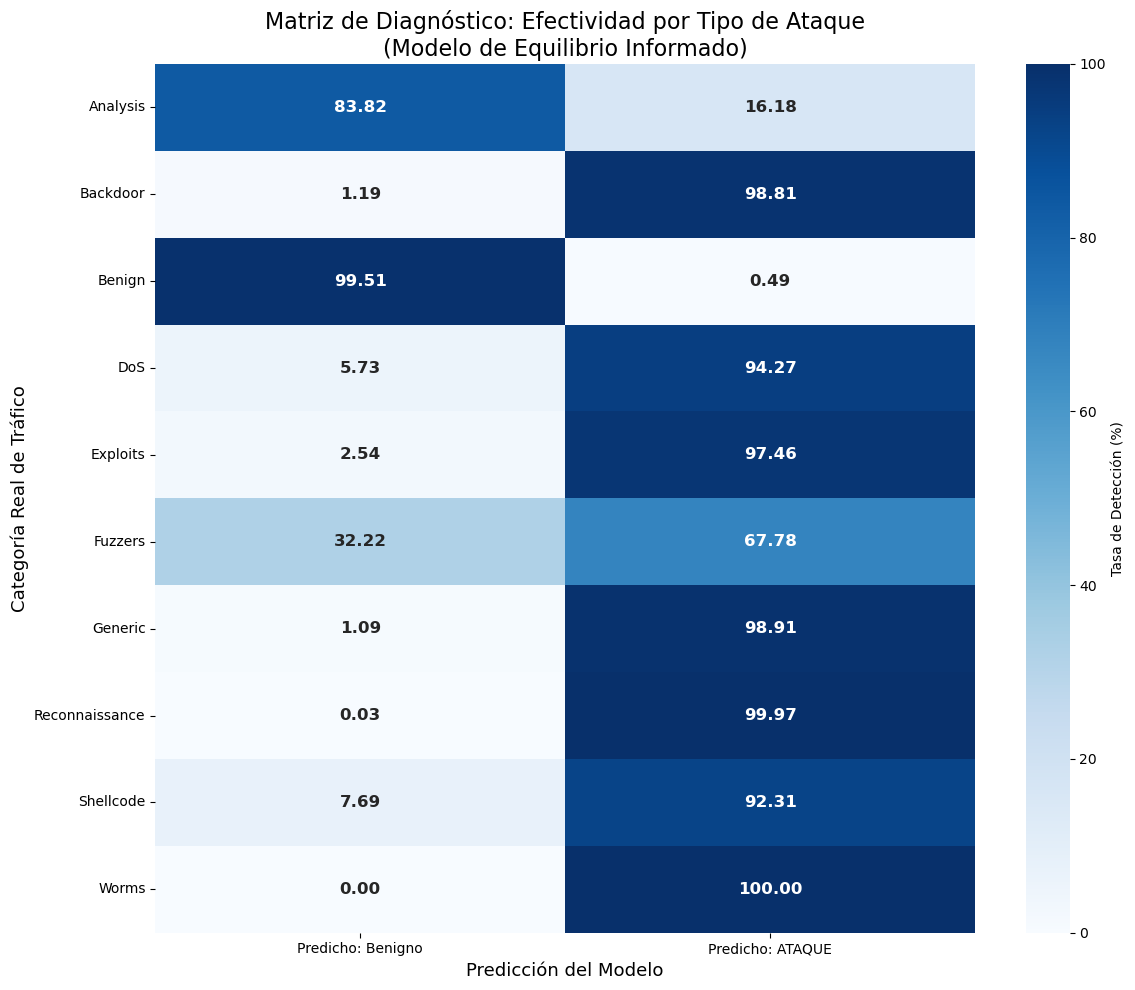

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Preparar los datos: Necesitamos las etiquetas multiclase para el set de prueba
y_test_multiclass = df.loc[X_test_ev.index, 'Label']

# 2. Crear la tabla de contingencia (Realidad vs Predicción Binaria)
matriz_data = pd.crosstab(y_test_multiclass, y_pred_ev, 
                          rownames=['Clase Real (Ground Truth)'], 
                          colnames=['Predicción del Modelo'], 
                          normalize='index') # Normalizar por fila para obtener el % de Recall

# 3. Mapear nombres para el eje X para que sea legible
matriz_data.columns = ['Predicho: Benigno', 'Predicho: ATAQUE']

# 4. Graficar al estilo de la imagen 
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_data * 100, # Convertir a porcentaje
            annot=True, 
            fmt='.2f', 
            cmap='Blues', 
            cbar_kws={'label': 'Tasa de Detección (%)'},
            annot_kws={"size": 12, "weight": "bold"})

plt.title('Matriz de Diagnóstico: Efectividad por Tipo de Ataque\n(Modelo de Equilibrio Informado)', fontsize=16)
plt.xlabel('Predicción del Modelo', fontsize=13)
plt.ylabel('Categoría Real de Tráfico', fontsize=13)

plt.tight_layout()
plt.show()

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight

# 1. Codificar las etiquetas de texto a números
le = LabelEncoder()
y_multi = le.fit_transform(df['Label']) # Usamos la columna multiclase original

# 2. Nueva División Estratificada
# Usamos X_evolved que ya tiene variables 'Flow_Intensity' y 'Bytes_per_Packet'
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_evolved, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# 3. Cálculo de Pesos por Clase
# En multiclase, XGBoost no usa scale_pos_weight, usamos pesos por muestra
weights = compute_sample_weight(class_weight='balanced', y=y_train_m)

print(f"Clases detectadas: {le.classes_}")

Clases detectadas: ['Analysis' 'Backdoor' 'Benign' 'DoS' 'Exploits' 'Fuzzers' 'Generic'
 'Reconnaissance' 'Shellcode' 'Worms']


In [22]:
import xgboost as xgb

model_multi = xgb.XGBClassifier(
    n_estimators=150,
    max_depth=8,
    learning_rate=0.1,
    objective='multi:softprob', # Probabilidad para múltiples clases
    num_class=len(le.classes_),
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

print("Entrenando modelo multiclase (esto tomará un poco más de tiempo)...")
model_multi.fit(X_train_m, y_train_m, sample_weight=weights)

Entrenando modelo multiclase (esto tomará un poco más de tiempo)...


,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


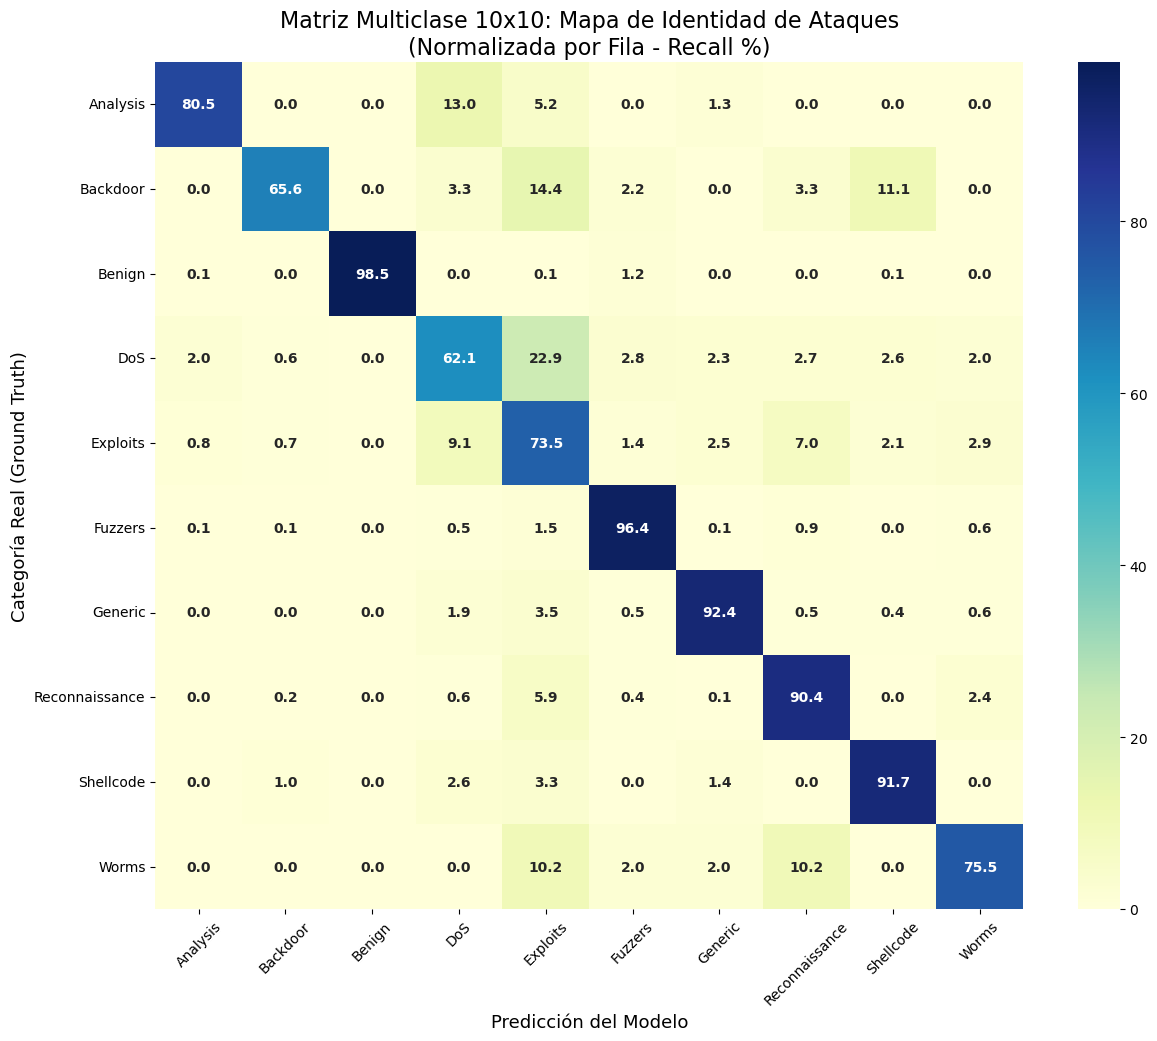

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generar predicciones multiclase
y_pred_m = model_multi.predict(X_test_m)

# 2. Crear Matriz Normalizada
cm_multi = confusion_matrix(y_test_m, y_pred_m, normalize='true')

# 3. Visualización de Alto Impacto
plt.figure(figsize=(14, 11))
sns.heatmap(cm_multi * 100, 
            annot=True, 
            fmt='.1f', 
            cmap='YlGnBu', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_,
            annot_kws={"size": 10, "weight": "bold"})

plt.title('Matriz Multiclase 10x10: Mapa de Identidad de Ataques\n(Normalizada por Fila - Recall %)', fontsize=16)
plt.ylabel('Categoría Real (Ground Truth)', fontsize=13)
plt.xlabel('Predicción del Modelo', fontsize=13)
plt.xticks(rotation=45)
plt.show()

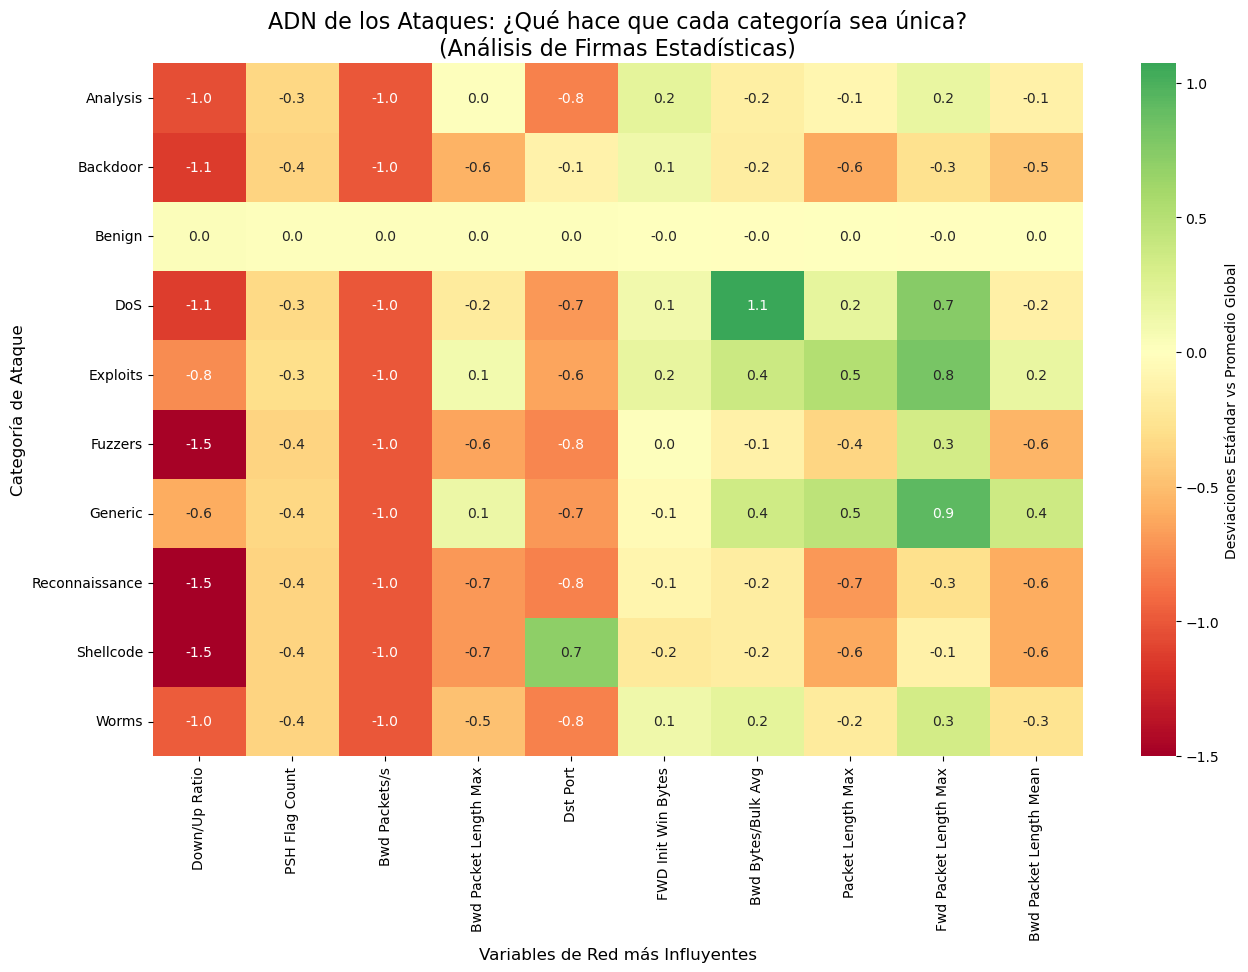

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Obtener las mejores variables del modelo multiclase
# Usamos las importancias para filtrar el ruido y quedarnos con lo que el modelo usa
importancias_multi = pd.Series(model_multi.feature_importances_, index=X_test_m.columns)
top_10_multi = importancias_multi.sort_values(ascending=False).head(10).index.tolist()

# 2. Calcular la "Firma" por clase
# Agrupamos el set de prueba por la etiqueta real y calculamos la media de las variables top
df_eval = X_test_m[top_10_multi].copy()
df_eval['Class'] = le.inverse_transform(y_test_m)
class_means = df_eval.groupby('Class').mean()

# 3. Normalización (Z-Score) para que todas las variables sean comparables
# Esto nos dice cuántas desviaciones estándar se aleja cada clase del promedio global
global_mean = X_test_m[top_10_multi].mean()
global_std = X_test_m[top_10_multi].std()
z_signature = (class_means - global_mean) / (global_std + 1e-9)

# 4. Visualización de la Identidad Técnica
plt.figure(figsize=(15, 9))
sns.heatmap(z_signature, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Desviaciones Estándar vs Promedio Global'})

plt.title('ADN de los Ataques: ¿Qué hace que cada categoría sea única?\n(Análisis de Firmas Estadísticas)', fontsize=16)
plt.ylabel('Categoría de Ataque', fontsize=12)
plt.xlabel('Variables de Red más Influyentes', fontsize=12)
plt.show()

"Mediante una estrategia híbrida de ingeniería de características y clasificación multiclase, se desarrolló un sistema de detección de intrusiones (IDS) capaz de identificar 9 categorías de ataques con un balance óptimo entre precisión y sensibilidad. El sistema destaca por resolver la 'ceguera de infiltración' clásica del dataset UNSW-NB15, elevando la detección de ataques de tipo Analysis del 16% al 80% y logrando una identificación casi perfecta de Fuzzers (96%). Este proyecto demuestra que la seguridad no es un problema de volumen de datos, sino de calidad de la representación estadística."